Libraries for this notebook and for the core components

In [1]:
# file: core_mps.py
from core import *
import sys
if './seemps' not in sys.path:
    sys.path = ['./seemps'] + sys.path
import math
import numpy as np
import numpy.linalg
import scipy.linalg
import matplotlib.pyplot as plt
from numpy import cos, sin, exp, sqrt
from numpy import pi as π
epsilon = np.finfo(np.float64).eps
import mps
import mps.state
from mps.state import CanonicalMPS, MPS
from mps.state import DEFAULT_TOLERANCE
from mps.mpo import MPO, MPOList
import os.path
import pickle

In [2]:
from quantum_plots import *

Global props:
fontsizes :
     tiny :  6
     scriptsize :  8
     footnotesize :  9
     small :  10
     normalsize :  11
     large :  12
     Large :  14
     LARGE :  17
     huge :  20
     Huge :  25
colors :
     quantumviolet :  #53257F
     quantumgray :  #555555


## Gaussian MPS

### a) General form

We write a sampling of a Gaussian state using MPS. The equation for the probability density is
$$p(\vec{x}) = \frac{1}{(2\pi)^{N/2}\mathrm{det}(\Sigma)}
\exp\left[-\frac{1}{2}(\vec{x}-\vec{\mu})^T\Sigma^{-2}(\vec{x}-\vec{\mu})\right]$$ 

The coordinates are sampled from a regular grid and the points are encoded as states of a quantum register. The $i$-th element of the vector coordinate $\vec{x},$ can take different values, labeled by the integer $s$
$$x_{is} - \mu =  \frac{b_i+a_i}{2} + \frac{b_i-a_i}{2}s=c_i + r_{is}.$$
Note that we have split the coordinate $x_i$ into a center $c_i$ and a displacement $r_{is}.$
In this encoding, the integer $s$ takes both positive and negative values,
$$s = \sum_{n=1}^m 2^{m-n} (-1)^{s_n},$$
depending on the state of $m$ qubit states $\{s_1,s_2,\ldots,s_m\}$. 

If we define $C=\Sigma^{-2}/2,$ the exponent for a fixed value of $s$ is
$$E=\sum_{i,j}\sum_{s_i,s_j}(r_{is_i}+c_i) C_{ij} (r_{js_j} +c_j).$$

Adding the bits we have
$$E = \sum_{ij,nn'} s_{i}^n J_{in,jn'}s_{j}^{n'} + \sum_{in} h_{in}s_{i}^{n} + E_0,$$
with the coupling
$$J_{in,in'} = \frac{\delta_i \delta_j}{2^{n+n'}} C_{ij},$$
the magnetic field
$$h_{in} = 2\sum_{j}c_jC_{ij}\frac{\delta_i}{2^n},$$
and the offset can accommodate also the normalization
$$E_0 = \sum_{ij}c_ia_jC_{ij} + \log((2\pi)^{N/2}\mathrm{det}(\Sigma)).$$ 

The following code constructs those matrices and vectors

In [3]:
# file: core_mps.py

def Gaussian2Ising(m, Σ, a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    Σ = np.asarray(Σ)
    d = len(Σ)
    assert len(a) == len(b) == len(Σ)
    #
    # Determine the interval
    δ = (b-a)/2
    c = (a+b)/2-δ/2**m
    #
    # Construct all coordinates
    x = np.arange(2**m)
    s = np.array([(x >> (m-i))&1 for i in range(1,m+1)])
    s = (2*s-1)
    x = s.T @ (1/2**np.arange(1,m+1))
    x = δ * x.reshape(2**m,1) + c
    #
    # Construct quadratic form
    C = 0.5 * numpy.linalg.inv(Σ@Σ)
    r = np.kron(δ, 1.0/2**np.arange(1,m+1))
    J = np.kron(C, np.ones((m,m))) * np.outer(r, r)
    h = np.kron(((2*c) @ C), np.ones(m)) * r
    δx = 2*δ/2**m
    E0 = c @ C @ c + np.log((2*π)**(d/2.0)*np.linalg.det(Σ)) - np.sum(np.log(δx))
    return J,h,E0,x,s

A crude check of this is to test it with vectors

In [4]:
def test1d(m, σ, a=None, b=None):
    if b is None:
        b = 7*σ
    if a is None:
        a = -b
    J, h, E0, x, s = Gaussian2Ising(m, [[σ]], [a], [b])
    #
    # Construct the exponent
    E = np.sum(s * (J @ s), 0) + h @ s + E0
    #
    # Construct wavefunction
    p = np.exp(-E)
    print(f'Normalization: {np.sum(p)}')
    return p, x, s

Normalization: 0.9999999999974086


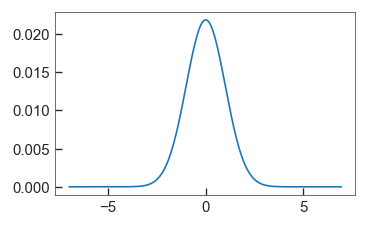

In [5]:
aux_p, aux_x, aux_s = test1d(8, 1.0)
fig = plot_setup()
plt.plot(aux_x, aux_p)

### b) General Ising MPO

The Gaussian probability distribution can be represented as a partition function
$$\psi(\vec{s}) \propto \exp(-\beta H)$$
with the effective Hamiltonian
$$H=\sum_{uv} J_{uv}s_us_v + \sum_u h_u + E_0.$$

We can represent this partition function as a product of operators
$$e^{-\beta H} = \prod_{u=0}^L \exp\left(-\beta \left[2\sum_{v>u} J_{uv}s_us_v + s_u(h_u+J_{uu}) + \frac{1}{L}E_0\right]\right)$$
acting one after another onto the trivial probability distribution
$$\xi_e(\vec{s}) = 1.$$

The initial state $\xi_e$ and the operators will be represented in tensor network form, using matrix-product states (MPS) and matrix-product operators (MPO). These forms allow for an efficient estimation of the action of the operators onto the state, provided that correlations do not blow up.

In [6]:
# file: core_mps.py

def all_entropies(ψ):
    return [CanonicalMPS(ψ._data,center=i).entanglement_entropyAtCenter()
            for i in range(ψ.size)]

In [7]:
# file: core_mps.py

def flip(ψ, where):
    A = ψ[where]
    A = np.einsum('ij,ajb->aib', np.array([[0,1],[1,0]]), A)
    return MPS([A if i == where else B for i,B in enumerate(ψ)])

In [8]:
# file: core_mps.py
def GaussianMPS(m, Σ, a=None, b=None, d=1, GR=True, reorder=False, fft=False, debug=[], **kwdargs):
    
    def IsingMPOs(β, J, h, E0=0.):
        L = len(J)
        def tensor(u,v):
            A = np.zeros((2,2,2,2), dtype=np.float64)
            if v == u:
                A[1,1,1,1] = 1.
                A[0,0,0,0] = 1.
            else:
                fac = β*J[v,u]
                A[1,1,1,1] = exp(-fac)
                A[1,0,0,1] = exp(+fac)
                A[0,1,1,0] = exp(+fac)
                A[0,0,0,0] = exp(-fac)
            A[:,:,:,0] *= np.exp(-β*(E0/L+J[u,u]-h[u])/L)
            A[:,:,:,1] *= np.exp(-β*(E0/L+J[u,u]+h[u])/L)
            if v==L-1:
                A = np.einsum('aijb->aij', A).reshape((A.shape[0],2,2,1))
            if v==0:
                A = np.einsum('aijb->ijb', A).reshape((1,2,2,A.shape[-1]))
            return A
        return MPOList([MPO([tensor(u,v) for v in range(L)], **kwdargs) for u in range(L)])

    Σ = Σ * np.ones((d,d))
    d = len(Σ)
    σ, _ = scipy.linalg.eigh(Σ)
    if b is None:
        b = 7*max(σ)
    if a is None:
        a = -b
    a *= np.ones(d)
    b *= np.ones(d)
    if GR:
        β = 0.5
    else:
        β = 1.0
    J0, h0, E0, x, s = Gaussian2Ising(m, Σ, a*np.ones(d), b*np.ones(d))
    Jmax = np.trace(J0)*d
    Jmax = max(scipy.linalg.eigh(J0)[0])*d
    steps = max(int(Jmax/32),1)
    if np.isscalar(reorder):
        if reorder:
            ndx = [dim*m + n for n in range(m) for dim in range(d)]
        else:
            ndx = np.arange(m*d)
    else:
        ndx = reorder
        reorder = True
    J = J0[np.ix_(ndx,ndx)]
    h = h0[ndx]

    mpos = IsingMPOs(β/steps, J, h, E0)
    if debug:
        print(f'Running {steps} steps with β={β} (Jmax={Jmax})\nσ={σ}')
        if debug == 'mpos':
            for mpo in mpos:
                for (i,A) in enumerate(mpo):
                    print(f'A[{i}]=')
                    print(A)
    if GR:
        ψmps = MPS([np.ones((1,2,1))/np.sqrt(2.0)]*(m*d))
    else:
        ψmps = MPS([np.ones((1,2,1))]*(m*d))
    for i in range(steps):
        ψmps = mpos.apply(ψmps)
        if 'norm' in debug:
            print(f'error={ψmps.error()}, |ψ|^2={ψmps.norm2()}')
    totalerr = ψmps.error()
    if debug:
        print(f'Total estimated error {totalerr}')
    if (d <= 3) and (len(J) <= 20) and debug:
        D = 2**m
        if d==1:
            E = np.sum(s*(J0@s), 0) + h0@s + E0
            p1 = exp(-E)
        elif d==2:
            Jxx = J0[np.ix_(range(m),range(m))]
            Jxy = J0[np.ix_(range(m),range(m,2*m))]
            Jyy = J0[np.ix_(range(m,2*m),range(m,2*m))]
            Exx = np.sum(s*(Jxx @ s), 0) + h0[0:m]@s
            Eyy = np.sum(s*(Jyy @ s), 0) + h0[m:]@s
            Exy = 2*(s.T @ (Jxy @ s))
            p1 = exp(-Exx.reshape(D,1)-Eyy.reshape(1,D)-Exy-E0).flatten()
        elif d==3:
            rx = range(m)
            ry = range(m,2*m)
            rz = range(2*m,3*m)
            Jxx = J0[np.ix_(rx,rx)]
            Jxy = J0[np.ix_(rx,ry)]
            Jxz = J0[np.ix_(rx,rz)]
            Jyy = J0[np.ix_(ry,ry)]
            Jyz = J0[np.ix_(ry,rz)]
            Jzz = J0[np.ix_(rz,rz)]
            Exx = (np.sum(s*(Jxx @ s), 0) + h0[rx]@s).reshape(D,1,1)
            Eyy = (np.sum(s*(Jyy @ s), 0) + h0[ry]@s).reshape(1,D,1)
            Ezz = (np.sum(s*(Jzz @ s), 0) + h0[rz]@s).reshape(1,1,D)
            Exy = 2*(s.T @ (Jxy @ s)).reshape(D,D,1)
            Exz = 2*(s.T @ (Jxz @ s)).reshape(D,1,D)
            Eyz = 2*(s.T @ (Jyz @ s)).reshape(1,D,D)
            p1 = exp(-Exx-Eyy-Ezz-Exy-Exz-Eyz-E0).flatten()
        p1 /= np.sum(p1)
        p2 = ψmps.tovector()**2
        p2 /= np.sum(p2)
        if reorder:
            p2 = p2.reshape([2]*(d*m))
            p2 = np.moveaxis(p2, list(range(0,d*m)), ndx).flatten()
        realerr1 = np.sum(np.abs(p1-p2))
        realerr2 = np.linalg.norm(np.sqrt(p1)-np.sqrt(p2))
        print(f'Probability error {realerr1}, norm error {realerr2}')
        totalerr = realerr2
    if d<=2 and 'plot' in debug:
        if d==2:
            p1 = np.sum(p1.reshape(2**m,2**m),1)
            p2 = np.sum(p2.reshape(2**m,2**m),1)
        fig = plot_setup(aspect_ratio=0.5/1.62,wide=True)
        ax = fig.add_subplot(1,2,1)
        ax.plot(p1, '-o', label='numerically exact')
        ax.plot(p2, '-', label='mps (tol=1e-16)')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$p(x)$')
        ax.set_yscale('log')
        ax = fig.add_subplot(1,2,2)
        S = all_entropies(ψmps)
        ax.plot(S)
        ax.set_xlabel('$k$')
        ax.set_ylabel('$S(\\rho^{(m,k)})$')
        plt.tight_layout()
    if isinstance(ψmps, CanonicalMPS):
        ψmps._error = totalerr**2
    return ψmps

### c) One-dimensional analysis

This example shows how to concatenate the MPO's to build a 1D Gaussian state. It also shows the entropy of entanglement with respect to all bipartitions.

Running 1 steps with β=0.5 (Jmax=32.666542053222656)
σ=[0.5]
error=2.2269253297285233e-13, |ψ|^2=1.0
Total estimated error 2.2269253297285233e-13
Probability error 1.0035512246462303e-07, norm error 7.185727318577426e-07


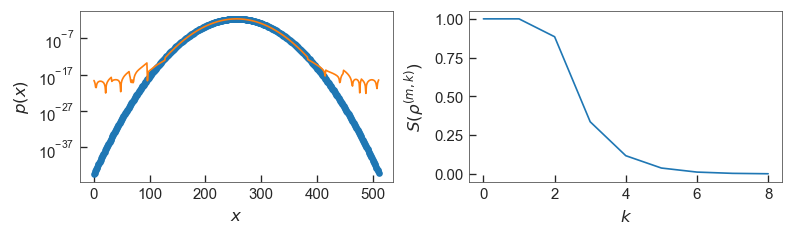

In [9]:
if True:
    aux_ψ = GaussianMPS(9, 0.5, a=-7, b=7, GR=True, simplify=True, normalize=True, tolerance=1e-14,
                        debug='norm-plot')

Using this, we can build various states, with different widths.

In [10]:
def test(M=10, tolerance=1e-16):
    σs = np.linspace(0.1,5.0,30)
    data = np.array([
         (max(all_entropies(ψ)), np.sqrt(ψ.error()), ψ.norm2())
         for σ in σs
         for ψ in [GaussianMPS(M, σ, a=-7, b=7, GR=True, simplify=True, normalize=True, debug='norm')]
    ])
    fig = plot_setup(aspect_ratio=0.6/1.62,wide=True)
    ax = fig.add_subplot(1,2,1)
    ax.plot(σs, data[:,0])
    ax.set_xlabel('$\\sigma$')
    ax.set_ylabel('$\\mathrm{max}(S)$')
    ax = fig.add_subplot(1,2,2)
    ax.plot(σs, data[:,1], label="$\\varepsilon$")
    ax.plot(σs, data[:,2], label="$\\Vert{\\psi}\\Vert$")
    ax.set_yscale('log')
    ax.set_xlabel('$\\sigma$')
    ax.legend()

We reproduce the same results as for exact states in 1D: entropy is at most 1 ebit. It goes down when the width exceeds the discretization interval.

Running 25 steps with β=0.5 (Jmax=816.6658878326415)
σ=[0.1]
error=5.306615753965961e-15, |ψ|^2=1.0
error=2.5480970442448606e-14, |ψ|^2=1.0
error=4.966117406239303e-14, |ψ|^2=1.0
error=8.330426354561887e-14, |ψ|^2=1.0000000000000002
error=1.2810627876857208e-13, |ψ|^2=1.0
error=2.1100220378729972e-13, |ψ|^2=1.0
error=3.176488518886311e-13, |ψ|^2=1.0
error=4.3438553786385413e-13, |ψ|^2=1.0000000000000002
error=5.56965686808484e-13, |ψ|^2=0.9999999999999999
error=6.051462616725195e-13, |ψ|^2=0.9999999999999999
error=7.044646644366454e-13, |ψ|^2=0.9999999999999999
error=9.927456261868183e-13, |ψ|^2=1.0
error=1.195109595915443e-12, |ψ|^2=1.0
error=1.324304615750841e-12, |ψ|^2=0.9999999999999998
error=1.3486666048466005e-12, |ψ|^2=1.0
error=1.4738072193992731e-12, |ψ|^2=1.0
error=1.6044989490750714e-12, |ψ|^2=1.0
error=1.7130491357043609e-12, |ψ|^2=1.0000000000000002
error=1.8318790345518107e-12, |ψ|^2=1.0
error=1.8605122887619454e-12, |ψ|^2=1.0
error=2.0318176997614533e-12, |ψ|^2=1.0000000

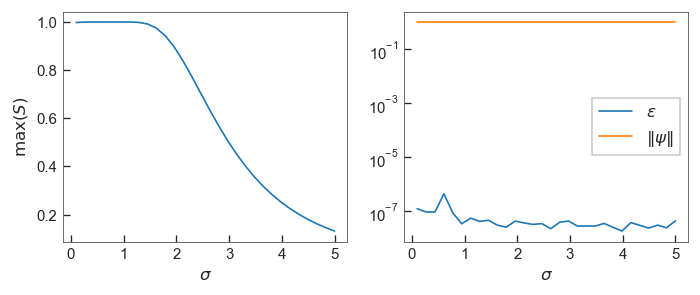

In [11]:
test(M=10, tolerance=1e-16)

### d) Two-dimensional analysis

Construct the best MPS approximation to normal and squeezed 2D Gaussian states, using the iterated MPO method. Once built, estimate the entropies of all left-right bipartitions.

The following code is rather numerically intensive. It is written to be launched as MPI jobs in our cluster, using, for instance
```
mpirun -n 5 python -u job-2d-m5.py
```
It can run sequentially if you modify `make_entropies2d()` to avoid using the MPI `Manager()` class.

In [ ]:
# file: mpi_mps_entropies2d.py

from core_mps import *
import os, sys, os.path
from mpijobs import Manager

def entropies2d(m, σ, θ, reorder=False):
    ψ = GaussianMPS(m, cmatrix2d([1.0, σ], θ), a=[-7,-7], b=[7,7],
                    simplify=True, normalize=True, reorder=reorder, debug='norm')
    χ = [A.shape for A in ψ]
    return (σ, all_entropies(ψ), ψ.norm2(), np.sqrt(ψ.error()), χ, m, θ, reorder)
    
def make_entropies2d(M=10, filename='data-mps/entropies2d-m10-mps.pkl'):
    mgr = Manager(debug=True)
    if mgr.isroot and os.path.exists(filename):
        os.remove(filename)
    σs = np.linspace(0.1,1.,41)
    mgr.run([(entropies2d, M, σ, π/4.) for σ in σs], filename)
    mgr.run([(entropies2d, M, σ, 0., True) for σ in σs], filename)
    mgr.run([(entropies2d, M, σ, 0.) for σ in σs], filename)

In [ ]:
# file: job-2d-m5.py
from mpi_mps_entropies2d import *
make_entropies2d(M=5, filename='data-mps/entropies2d-m5-mps.pkl')

In [ ]:
# file: job-2d-m7.py
from mpi_mps_entropies2d import *
make_entropies2d(M=7, filename='data-mps/entropies2d-m7-mps.pkl')

In [ ]:
# file: job-2d-m9.py
from mpi_mps_entropies2d import *
make_entropies2d(M=9, filename='data-mps/entropies2d-m9-mps.pkl')

In [ ]:
# file: job-2d-m11.py
from mpi_mps_entropies2d import *
make_entropies2d(M=11, filename='data-mps/entropies2d-m11-mps.pkl')

In [ ]:
# file: job-2d-m14.py
from mpi_mps_entropies2d import *
make_entropies2d(M=14, filename='data-mps/entropies2d-m14-mps.pkl')

In [ ]:
# file: job-2d-m16.py
from mpi_mps_entropies2d import *
make_entropies2d(M=16, filename='data-mps/entropies2d-m16-mps.pkl')

In [ ]:
# file: job-2d-m18.py
from mpi_mps_entropies2d import *
make_entropies2d(M=18, filename='data-mps/entropies2d-m18-mps.pkl')

### e) 3D systems

Construct the best MPS approximation to normal and squeezed 3D Gaussian states, using the iterated MPO method. Once built, estimate the entropies of all left-right bipartitions.

The following code is rather numerically intensive. It is written to be launched as MPI jobs in our cluster, using, for instance
```
mpirun -n 5 python -u job-3d-m5.py
```
It can run sequentially if you modify `make_entropies3d()` to avoid using the MPI `Manager()` class.

In [ ]:
# file: mpi_mps_entropies3d.py

from core_mps import *
import os, sys, os.path
from mpijobs import Manager

def entropies(m, σ, θ, reorder=False):
    ψ = GaussianMPS(m, cmatrix3d([σ, 1.0, σ], θ, θ), a=[-7,-7,-7], b=[7,7,7],
                    simplify=True, normalize=True, reorder=reorder, debug='norm')
    χ = [A.shape for A in ψ]
    return (σ, all_entropies(ψ), ψ.norm2(), np.sqrt(ψ.error()), χ, m, θ)
    
def make_entropies3d(M=10, filename='data/entropies2d-m10-mps.pkl'):
    mgr = Manager(debug=True)
    if mgr.isroot and os.path.exists(filename):
        os.remove(filename)
    σs = np.linspace(0.1,1.,41)
    mgr.run([(entropies, M, σ, π/4.) for σ in σs], filename)
    mgr.run([(entropies, M, σ, 0., True) for σ in σs], filename)
    mgr.run([(entropies, M, σ, 0.) for σ in σs], filename)

In [ ]:
# file: job-3d-m5.py
from mpi_mps_entropies3d import *
make_entropies3d(M=5, filename='data-mps/entropies3d-m5-mps.pkl')

In [ ]:
# file: job-3d-m7.py
from mpi_mps_entropies3d import *
make_entropies3d(M=7, filename='data-mps/entropies3d-m7-mps.pkl')

In [ ]:
# file: job-3d-m9.py
from mpi_mps_entropies3d import *
make_entropies3d(M=9, filename='data-mps/entropies3d-m9-mps.pkl')

In [ ]:
# file: job-3d-m11.py
from mpi_mps_entropies3d import *
make_entropies3d(M=11, filename='data-mps/entropies3d-m11-mps.pkl')

In [ ]:
# file: job-3d-m12.py
from mpi_mps_entropies3d import *
make_entropies3d(M=11, filename='data-mps/entropies3d-m12-mps.pkl')

In [ ]:
# file: job-3d-m13.py
from mpi_mps_entropies3d import *
make_entropies3d(M=11, filename='data-mps/entropies3d-m13-mps.pkl')